In [1]:
import pandas as pd
import numpy as np

import gzip
import os
import json

import matplotlib.pyplot as plt
%matplotlib inline

import gc
gc.enable()

import warnings
warnings.filterwarnings("ignore")
pd.set_option('max_columns',None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### Data
Due to file sizes the data won't be uploaded to GitHub. The data can be found at [https://nijianmo.github.io/amazon/index.html](https://nijianmo.github.io/amazon/index.html). Only the book reviews and book metadata are used.

In [2]:
filenames = [
    'Amazon_meta_Books.json.gz',
    'AmazonBooks.json.gz'
]

print('Compressed Files')
for filename in filenames:
    size = round(os.path.getsize(filename) / 1e+9, 2)
    print(
        filename + ': ' + str(size) + ' gb'
    )

Compressed Files
Amazon_meta_Books.json.gz: 1.22 gb
AmazonBooks.json.gz: 11.81 gb


## Initial problems
  + Original files were too large to use on my laptop
  + Had to come up with custom data loading functions when dealing with such large files
    + Conventional libraries like Pandas and Dask were not able to handle the files
  + Have to filter for feasibility
    + Ideally would use 100% of the data, however, books with no or very little reviews don't model well

### Amazon book metadata import

In [3]:
%%time

def load_amazon_metadata(file_name, nrows = 10000000):
    counter = 0
    data = []
    # loading compressed json file
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            # avoid empty category lists and rows that are not books
            if ('Books' in d['category']):
                # only pulling necessary fields to reduce memory allocation
                # amazon asin = book_id
                d2 = {}
                d2['book_id'] = d['asin']
                d2['title'] = d['title'].lower() # force lowercase
                d2['category'] = [x.lower() for x in d['category']] # force lowercase
                data.append(d2)
                counter += 1
            # nrow cutoff
            if (nrows is not None) and (counter > nrows):
                break
    return data
# load data
amazon_books = load_amazon_metadata(os.path.join('Amazon_meta_Books.json.gz'))
len(amazon_books)

Wall time: 1min 19s


2545520

In [4]:
%%time
# create amazon book metadata dataframe
amazon_books_df = pd.DataFrame(amazon_books).drop_duplicates(subset=['book_id']).reset_index(drop=True)

print(amazon_books_df.shape)
amazon_books_df.head()

(2543936, 3)
Wall time: 3.48 s


,book_id,title,category
0,000047715X,mksap 16 audio companion: medical knowledge se...,"[books, new, used & rental textbooks, medicine..."
1,0000004545,"flex! discography of north american punk, hard...","[books, arts & photography, music]"
2,0000013765,heavenly highway hymns: shaped-note hymnal,"[books, arts & photography, music]"
3,0000555010,principles of analgesic use in the treatment o...,"[books, new, used & rental textbooks, medicine..."
4,0000477141,mksap 15 audio companion,"[books, medical books, medicine]"


### Wrangling/cleaning categories

#### Filter category list index 1
The category list is a hierachy with all index 0's being 'books'. The higher the index value the finer grain category.

In [5]:
# getting a unique list of genres in the index -1 position
idx1_list = []
for sublist in amazon_books_df.category.tolist():
    idx1 = sublist[1]
    if idx1 not in idx1_list:
        idx1_list.append(idx1)
idx1_list

['new, used & rental textbooks',
 'arts & photography',
 'medical books',
 'education & teaching',
 'humor & entertainment',
 'engineering & transportation',
 'literature & fiction',
 "children's books",
 'biographies & memoirs',
 'mystery, thriller & suspense',
 'reference',
 'christian books & bibles',
 'science fiction & fantasy',
 'teen & young adult',
 'crafts, hobbies & home',
 'self-help',
 'history',
 'travel',
 'sports & outdoors',
 'politics & social sciences',
 'comics & graphic novels',
 'science & math',
 'business & money',
 'religion & spirituality',
 'cookbooks, food & wine',
 'health, fitness & dieting',
 'romance',
 'lesbian, gay, bisexual & transgender books',
 'parenting & relationships',
 'literature &amp; fiction',
 'health, fitness &amp; dieting',
 'biographies &amp; memoirs',
 'engineering &amp; transportation',
 'science &amp; math',
 'sports &amp; outdoors',
 'cookbooks, food &amp; wine',
 'politics &amp; social sciences',
 'arts &amp; photography',
 'religion

In [6]:
# getting a unique list of high level genres and a list of low level literature & fiction genres
idx1_list = []
for sublist in amazon_books_df.category.tolist():
    if 'literature' in sublist[1]:
        new_cat = 'literature & fiction: ' + sublist[-1]
        if new_cat not in idx1_list:
            idx1_list.append(new_cat)
    elif sublist[1] not in idx1_list:
        idx1_list.append(sublist[1])
sorted(idx1_list)

['arts & photography',
 'arts &amp; photography',
 'biographies & memoirs',
 'biographies &amp; memoirs',
 'business & money',
 'business &amp; money',
 'calendars',
 "children's books",
 'christian books & bibles',
 'christian books &amp; bibles',
 'comics & graphic novels',
 'comics &amp; graphic novels',
 'computers & technology',
 'computers &amp; technology',
 'cookbooks, food & wine',
 'cookbooks, food &amp; wine',
 'crafts, hobbies & home',
 'crafts, hobbies &amp; home',
 'education & teaching',
 'education &amp; teaching',
 'engineering & transportation',
 'engineering &amp; transportation',
 'health, fitness & dieting',
 'health, fitness &amp; dieting',
 'history',
 'humor & entertainment',
 'humor &amp; entertainment',
 'law',
 'lesbian, gay, bisexual & transgender books',
 'lesbian, gay, bisexual &amp; transgender books',
 'literature & fiction: </span>',
 'literature & fiction: action & adventure',
 'literature & fiction: action &amp; adventure',
 'literature & fiction: afr

In [24]:
# top 10 most unique books w/ more than 50 reviews
keep_cats = [
    "mystery, thriller & suspense",
    'mystery, thriller &amp; suspense',
    "genre fiction",
    "romance",
    "christian books & bibles",
    'christian books &amp; bibles',
    "children's books",
    "science fiction & fantasy",
    'science fiction &amp; fantasy',
    "biographies & memoirs",
    'biographies &amp; memoirs',
    "crafts, hobbies & home",
    'crafts, hobbies &amp; home',
    "cookbooks, food & wine",
    'cookbooks, food &amp; wine',
    "health, fitness & dieting",
    'health, fitness &amp; dieting',
]

# literature and fiction sub categories that should be in mystery suspense thriller
myst_thril_subcats = ['mystery','thriller & suspense','mystery, thriller & suspense','thrillers']
# literature and fiction sub categories that should be in scifi/fantasy
scifi_fant_subcats = ['fantasy','science fiction & fantasy']
# literature and fiction sub categories I want to keep
fiction_cats = [
    'genre fiction',
    'action & adventure',
    'humor & satire',
    'horror',
    'psychological',
    'humorous',
    'war',
    'military',
    'epic',
    'dark humor'
]

In [25]:
# getting a unique list of high level genres and a list of low level literature & fiction genres
new_cats = []
for sublist in amazon_books_df.category.tolist():
    if ('literature' in sublist[1]) & any(x in sublist[-1] for x in myst_thril_subcats):
        new_cats.append("mystery, thriller & suspense")
    elif ('literature' in sublist[1]) & any(x in sublist[-1] for x in scifi_fant_subcats):
        new_cats.append("science fiction & fantasy")
    elif ('literature' in sublist[1]) & any(x in sublist[-1] for x in fiction_cats):
        new_cats.append("genre fiction")
    else:
        new_cats.append(sublist[1])
        
amazon_books_df.category = new_cats
# cleaning up some of the strings
amazon_books_df.category = amazon_books_df.category.replace('amp;','', regex=True)

amazon_books_df = amazon_books_df.loc[amazon_books_df.category.isin(keep_cats)].reset_index(drop=True)
print(amazon_books_df.shape)
amazon_books_df.head()

(1009069, 3)


,book_id,title,category
0,0001061100,chess for children,children's books
1,0001061240,the golden treasury of poetry,children's books
2,0001062395,dinosaurs: a pop-up book,children's books
3,0001047965,shadowlands,biographies & memoirs
4,0001203045,hilda boswell's treasury of children's stories,children's books


In [27]:
amazon_books_df.category.value_counts()

children's books                241090
christian books & bibles        150084
genre fiction                   119011
crafts, hobbies & home          100259
biographies & memoirs            91040
mystery, thriller & suspense     83848
science fiction & fantasy        61199
romance                          58533
cookbooks, food & wine           52466
health, fitness & dieting        51539
Name: category, dtype: int64

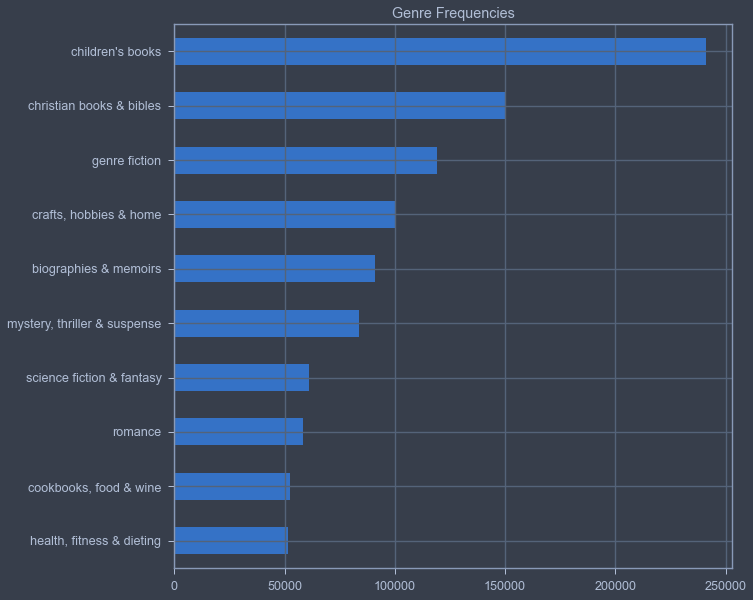

In [73]:
plt.figure(figsize=(10,10))
amazon_books_df.category.value_counts().plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Genre Frequencies')
plt.show()

In [45]:
amazon_books_df.shape

(1009069, 3)

### Amazon book reviews import

In [47]:
# getting list of asin's (book ids) to filter review data to
book_id_list = amazon_books_df.book_id.unique().tolist()

In [50]:
%%time

def load_amazon_review_data(file_name, nrows = 100000000):
    counter = 0
    data = []
    # loading compressed json file
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            # only verified reviews
            if d['verified'] == True:
                # only pulling necessary fields to reduce memory allocation
                d2 = {}
                d2['user_id'] = d.get('reviewerID')
                d2['book_id'] = d.get('asin')
                d2['rating'] = d.get('overall')
                d2['review_text'] = d.get('reviewText')

                data.append(d2)
                counter += 1
            # nrows break
            if (nrows is not None) and (counter > nrows):
                break
    return data
# load data
amazon_reviews = load_amazon_review_data(os.path.join('AmazonBooks.json.gz'))
len(amazon_reviews)

Wall time: 13min 8s


34759300

In [51]:
%%time
# create amazon reviews dataframe
amazon_reviews_df = pd.DataFrame(amazon_reviews)

# lowercase all text columns
amazon_reviews_df.review_text = amazon_reviews_df.review_text.str.lower()

print(amazon_reviews_df.shape)
amazon_reviews_df.head()

(34759300, 4)
Wall time: 51.5 s


,user_id,book_id,rating,review_text
0,A2ZB06582NXCIV,0001713353,5.0,"just as i remembered it, one of my favorites f..."
1,ACPQVNRD3Z09X,0001713353,5.0,it is a very cute book with great illustration...
2,AVP0HXC9FG790,0001713353,5.0,the kids loved it!
3,A32MQTLQQN44WW,0001713353,5.0,"i was just so hapoy to have found it, thank yo..."
4,A13CHIJPFCEP2M,0001713353,5.0,good comdition


In [54]:
amazon_reviews_df.isnull().sum()

user_id            0
book_id            0
rating             0
review_text    11818
dtype: int64

In [56]:
%%time
# filter amazon reviews to those with book metadata
# Pandas filtering was the fastest method I found. Older methods like list comprehensions and for loops we're taking a very long time
amazon_reviews_df = amazon_reviews_df.loc[amazon_reviews_df.book_id.isin(book_id_list)]
print(amazon_reviews_df.shape)
amazon_reviews_df.head()

(18659277, 4)
Wall time: 5.37 s


,user_id,book_id,rating,review_text
0,A2ZB06582NXCIV,0001713353,5.0,"just as i remembered it, one of my favorites f..."
1,ACPQVNRD3Z09X,0001713353,5.0,it is a very cute book with great illustration...
2,AVP0HXC9FG790,0001713353,5.0,the kids loved it!
3,A32MQTLQQN44WW,0001713353,5.0,"i was just so hapoy to have found it, thank yo..."
4,A13CHIJPFCEP2M,0001713353,5.0,good comdition


### Merge books and reviews

In [58]:
amazon_merge = (
    amazon_reviews_df
    .merge(amazon_books_df, how='left', on='book_id')
    .drop_duplicates()
    .reset_index(drop=True)
)
print(amazon_merge.shape)
amazon_merge.head()

(18635914, 6)


,user_id,book_id,rating,review_text,title,category
0,A2ZB06582NXCIV,0001713353,5.0,"just as i remembered it, one of my favorites f...","king, the mice and the cheese (beginner books)",children's books
1,ACPQVNRD3Z09X,0001713353,5.0,it is a very cute book with great illustration...,"king, the mice and the cheese (beginner books)",children's books
2,AVP0HXC9FG790,0001713353,5.0,the kids loved it!,"king, the mice and the cheese (beginner books)",children's books
3,A32MQTLQQN44WW,0001713353,5.0,"i was just so hapoy to have found it, thank yo...","king, the mice and the cheese (beginner books)",children's books
4,A13CHIJPFCEP2M,0001713353,5.0,good comdition,"king, the mice and the cheese (beginner books)",children's books


In [59]:
amazon_merge.isnull().sum()

user_id           0
book_id           0
rating            0
review_text    5435
title             0
category          0
dtype: int64

### Filter books/reviews based on number of reviews
  + Reduce data size
  + Cold start problem - unreviewed or hardly reviewed books won't be modelled well

In [66]:
review_counts = (
    amazon_merge.book_id
    .value_counts()
    .to_frame()
    .reset_index()
    .rename(columns={'book_id':'review_count','index':'book_id'})
    .assign(
        pct_total = lambda df_: df_.review_count / df_.review_count.sum(),
        pct_total_cumsum = lambda df_: df_.pct_total.cumsum()
    )
)
review_counts

,book_id,review_count,pct_total,pct_total_cumsum
0,038568231X,49574,2.660132e-03,0.002660
1,0297859382,36660,1.967169e-03,0.004627
2,0312577222,31501,1.690338e-03,0.006318
3,0099911701,28404,1.524154e-03,0.007842
4,0553418025,24777,1.329530e-03,0.009171
...,...,...,...,...
861487,1681521822,1,5.365983e-08,1.000000
861488,1681395282,1,5.365983e-08,1.000000
861489,0448190761,1,5.365983e-08,1.000000
861490,1681442884,1,5.365983e-08,1.000000


In [67]:
# keeping books that have >= 500 reviews
review_counts = review_counts.loc[review_counts.review_count >= 0].reset_index(drop=True)
# list of book_id's to keep
keep_book_ids = review_counts.book_id.tolist()
print(review_counts.shape)
review_counts.head()

(861492, 4)


,book_id,review_count,pct_total,pct_total_cumsum
0,038568231X,49574,0.002660,0.002660
1,0297859382,36660,0.001967,0.004627
2,0312577222,31501,0.001690,0.006318
3,0099911701,28404,0.001524,0.007842
4,0553418025,24777,0.001330,0.009171


In [68]:
amazon_merge_filtered = amazon_merge.loc[amazon_merge.book_id.isin(keep_book_ids)]
print(amazon_merge_filtered.shape)
amazon_merge_filtered.head()

(18635914, 6)


,user_id,book_id,rating,review_text,title,category
0,A2ZB06582NXCIV,0001713353,5.0,"just as i remembered it, one of my favorites f...","king, the mice and the cheese (beginner books)",children's books
1,ACPQVNRD3Z09X,0001713353,5.0,it is a very cute book with great illustration...,"king, the mice and the cheese (beginner books)",children's books
2,AVP0HXC9FG790,0001713353,5.0,the kids loved it!,"king, the mice and the cheese (beginner books)",children's books
3,A32MQTLQQN44WW,0001713353,5.0,"i was just so hapoy to have found it, thank yo...","king, the mice and the cheese (beginner books)",children's books
4,A13CHIJPFCEP2M,0001713353,5.0,good comdition,"king, the mice and the cheese (beginner books)",children's books


In [69]:
amazon_merge_filtered.groupby('category', as_index=False)['book_id'].nunique().sort_values(by='book_id', ascending=False)

,category,book_id
1,children's books,198830
2,christian books & bibles,129969
5,genre fiction,100306
4,"crafts, hobbies & home",91238
0,biographies & memoirs,77309
7,"mystery, thriller & suspense",71808
9,science fiction & fantasy,50613
8,romance,49301
3,"cookbooks, food & wine",47158
6,"health, fitness & dieting",44960


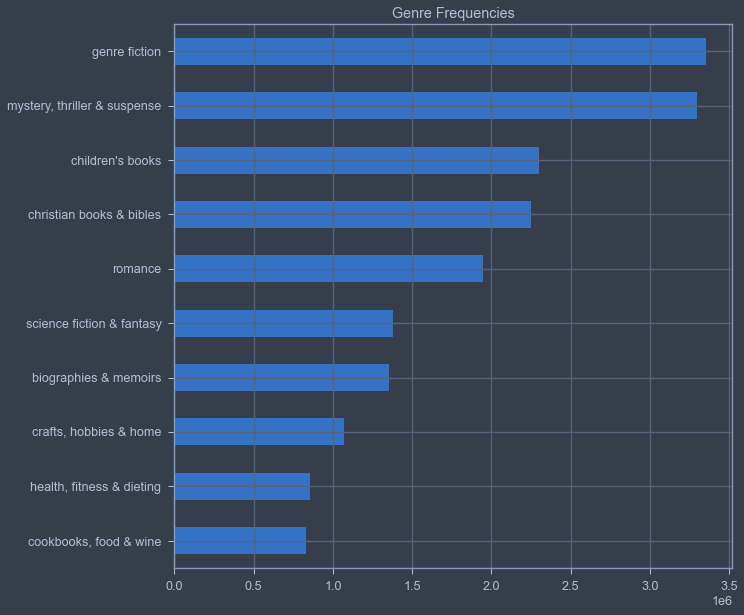

In [74]:
plt.figure(figsize=(10,10))
amazon_merge_filtered.category.value_counts().plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Genre Frequencies')
plt.show()

### Save to local

In [72]:
amazon_merge_filtered.to_pickle('amazon_top_10_cats_50plus_ratings.pkl')